In [84]:
!pip install gutenbergpy
!pip install catboost
!pip install transformers

In [85]:
import gutenbergpy.textget
from catboost import CatBoostClassifier, Pool
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch
from transformers import DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup



In [86]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('punkt')  # Download necessary data
nltk.download('stopwords')
import string
import re
from nltk import FreqDist
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    matthews_corrcoef,
    roc_auc_score,
    ConfusionMatrixDisplay)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
def get_text(id):
    # This gets a book by its gutenberg id number
    raw_book = gutenbergpy.textget.get_text_by_id(id) # with headers
    clean_book = gutenbergpy.textget.strip_headers(raw_book) # without headers
    return clean_book, raw_book
def clean_tokenize_filter(text):
  text = text.decode('utf-8')
  words = text.split()

  # Clean and join the words while preserving spaces and apostrophes
  cleaned_text = ' '.join([re.sub(r'[^a-zA-Z0-9\s\'".?!,:;()-]', '', word) for word in words])
  cleaned_text = cleaned_text.replace("'","")
  cleaned_text = cleaned_text.lower()

  # Tokenize the text
  tokens = word_tokenize(cleaned_text)

  stop_words = set(stopwords.words('english'))
  filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
  filtered_tokens = [word for word in filtered_tokens if word not in string.punctuation]
  filtered_tokens = [re.sub(r'[%s]+' % re.escape(string.punctuation), '', word) for word in filtered_tokens]
  # Remove empty strings resulting from removing punctuation
  filtered_tokens = [word for word in filtered_tokens if word and not word.isspace()]

  # Join the filtered tokens back into a single cleaned_text
  filtered_text = ' '.join(filtered_tokens)
  return cleaned_text, tokens, filtered_tokens, filtered_text
def encode_decode_text(text, target_encoding='utf-8'):
    try:
        # Attempt to decode the text using the target encoding
        decoded_text = text.decode(target_encoding)

        # If decoding is successful, return the decoded text
        return decoded_text
    except UnicodeDecodeError:
        # If decoding fails, assume the text is already in the target encoding
        return text.encode(target_encoding)
def process_df(df,author_list):
  processed_df = df[
    (df["Audio"] != "Audio\xa0\xa0") &
    (df["Language"] == "English") &
    (df["Author"].isin(author_list))
    ].reset_index()
  processed_df["Etext-No."] = processed_df["Etext-No."].astype(int)
  processed_df["Author"] = processed_df["Author"].apply(lambda x: x.split(", 1")[0])
  return processed_df

def get_middle_section_by_pct(input_string, percentage):
    words = input_string.split()
    total_words = len(words)
    middle_word_count = int(total_words * percentage)
    start_word = max(0, (total_words - middle_word_count) // 2)
    end_word = start_word + middle_word_count
    middle_words = ' '.join(words[start_word:end_word])
    return middle_words

def get_middle_section_by_words(input_string, num_words):
    words = input_string.split()
    middle_index = len(words) // 2
    return ' '.join(words[max(0, middle_index - num_words // 2):middle_index + num_words // 2])

def prepare_dictionary(clean_df, chunk_pct = None):
  dictionary = {}
  for author in list(clean_df["Author"].unique()):
    dictionary[author] = {}
  all_text = " ".encode('utf-8')
  for i,row in clean_df.loc[:].iterrows():
    no = row["Etext-No."]
    author, title = clean_df.loc[i,["Author","Title"]].values
    try:
      text, raw = get_text(no)
      if chunk_pct:
        try:
          text = text[len(text)//2 - chunk_pct:len(text)//2 + chunk_pct]
        except:
          print("can't get chunk")
          pass
      cleaned_text, tokens, filtered_tokens, filtered_text = clean_tokenize_filter(text)
      print(author,title," successfull")
      dictionary[author][title] = {"cleaned_text":cleaned_text, "tokens": tokens, "filtered_tokens": filtered_tokens, "filtered_text": filtered_text}
      all_text = all_text + text
    except:
      print(author,title," failed")
      pass
  text = text.decode('utf-8')
  return dictionary, all_text

def plot_pie_chart(dictionary, title):
  work_length_dict = {author: 0 for author in dictionary.keys()}
  for author in dictionary.keys():
    for work in dictionary[author].keys():
      work_length_dict[author] += len(dictionary[author][work]["filtered_text"].split(" "))

  df = pd.DataFrame.from_dict(work_length_dict, orient='index', columns=["Total Words"])
  ax = df.plot.pie(y="Total Words", figsize=(12, 8), legend=False, autopct='%1.1f%%', title=title, fontsize=6)
  ax.set_ylabel('')

def undersample_df(df, target_column_name):
    majority_class = df[df[target_column_name] == 0]
    minority_class = df[df[target_column_name] == 1]
    minority_class_size = len(minority_class)
    undersampled_majority = resample(majority_class, replace=False, n_samples=minority_class_size, random_state=42)
    undersampled_df = pd.concat([undersampled_majority, minority_class])
    undersampled_df = undersampled_df.sample(frac=1, random_state=42)

    return undersampled_df

def print_classification_metrics(y_test, predictions, labels):
    # Calculate and print various classification metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cohen_kappa = cohen_kappa_score(y_test, predictions)
    matthews_corr = matthews_corrcoef(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)

    disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions)
    return [accuracy, precision, recall, f1, cohen_kappa]

def print_split_stats(X_train, X_val, X_test, y_train, y_val, y_test, train, val, test):
  print("data target dist =\n",data["Target"].value_counts()/sum(data["Target"].value_counts()))
  total_samples = train.shape[0] + test.shape[0] + val.shape[0] + 1e-10
  print("train val test ratio = ",train.shape[0] / total_samples, val.shape[0] / total_samples, test.shape[0] / total_samples, )
  print("train val test target dist = ",train["Target"].value_counts()/sum(train["Target"].value_counts()),val["Target"].value_counts()/sum(val["Target"].value_counts()),test["Target"].value_counts()/sum(test["Target"].value_counts()))
  print("X_train shape = {}\n X_val shape = {}\n X_test shape = {}\n y_train shape = {}\n y_val shape = {}\n y_test shape = {}\n train shape = {}\n test shape = {}".format(X_train.shape,X_val .shape ,X_test .shape, y_train.shape, y_val.shape, y_test.shape, train.shape, test.shape))
  return train["Target"].value_counts()/sum(train["Target"].value_counts()),val["Target"].value_counts()/sum(val["Target"].value_counts()),test["Target"].value_counts()/sum(test["Target"].value_counts())

Read and Preprocess

In [88]:
df_sad = pd.read_excel("suicide_book_data.xlsx", sheet_name = 0)
df_happy = pd.read_excel("suicide_book_data.xlsx", sheet_name = 1)

In [89]:
# committed suicide
sad_authors = ["Woolf, Virginia, 1882-1941",'Zweig, Stefan, 1881-1942','Hemingway, Ernest, 1899-1961', 'Woolf, Leonard, 1880-1969','Nerval, Gérard de, 1808-1855','London, Jack, 1876-1916','Berryman, John, 1919-1988',
           'Sterling, George, 1869-1926','Peck, Harry Thurston, 1856-1914']
# depressed
suicidal = ['Fitzgerald, F. Scott (Francis Scott), 1896-1940','Poe, Edgar Allan, 1809-1849','Tolstoy, Leo, graf, 1828-1910','Verlaine, Paul, 1844-1896','Baldwin, James, 1841-1925','Kafka, Franz, 1883-1924',
            'Dostoyevsky, Fyodor, 1821-1881', 'Nietzsche, Friedrich Wilhelm, 1844-1900']
# happy neutral
happy_authors = ["Twain, Mark, 1835-1910","Shakespeare, William, 1564-1616","Dickens, Charles, 1812-1870","Wodehouse, P. G. (Pelham Grenville), 1881-1975","Austen, Jane, 1775-1817","Potter, Beatrix, 1866-1943","Alcott, Louisa May, 1832-1888","Milne, A. A. (Alan Alexander), 1882-1956","Verne, Jules, 1828-1905", "Westlake, Donald E., 1933-2008","Christie, Agatha, 1890-1976","Hugo, Victor, 1802-1885"]

sad_authors += suicidal

df_sad_processed = process_df(df_sad,sad_authors)
df_happy_processed = process_df(df_happy, happy_authors)

In [90]:
%%time
chunksize = None
sad_dict, sad_all_text = prepare_dictionary(df_sad_processed, chunksize)
happy_dict, happy_all_text = prepare_dictionary(df_happy_processed, chunksize)

Dostoyevsky, Fyodor Stavrogin's Confession and The Plan of The Life of a Great Sinner  successfull
Woolf, Virginia Jacob's Room  successfull
Woolf, Virginia Monday or Tuesday  successfull
Woolf, Virginia Night and Day  successfull
Woolf, Virginia Mr. Bennett and Mrs. Brown  successfull
Woolf, Virginia Mrs Dalloway in Bond Street  successfull
Woolf, Leonard Two Stories  successfull
Woolf, Virginia The Common Reader  successfull
Woolf, Virginia The Voyage Out  successfull
Zweig, Stefan Paul Verlaine  successfull
Zweig, Stefan Romain Rolland: The Man and His Work  successfull
Zweig, Stefan Émile Verhaeren  successfull
Zweig, Stefan Jeremiah: A Drama in Nine Scenes  successfull
Zweig, Stefan The Burning Secret  successfull
Hemingway, Ernest Three Stories & Ten Poems  successfull
Hemingway, Ernest In our time  successfull
Hemingway, Ernest The Sun Also Rises  successfull
Hemingway, Ernest Men without women  successfull
Poe, Edgar Allan The Works of Edgar Allan Poe — Volume 3  successfull
Po

Save

In [ ]:
#sad_to_save = (sad_all_text, sad_dict)
#with open(f"sad.pkl", 'wb') as pickle_file:
#    pickle.dump(sad_to_save, pickle_file)

#happy_to_save = (happy_all_text, happy_dict)
#with open(f"happy.pkl", 'wb') as pickle_file:
#    pickle.dump(happy_to_save, pickle_file)


In [ ]:
#!cp "sad.pkl" /content/drive/MyDrive/text_speech_project/
#!cp "happy.pkl" /content/drive/MyDrive/text_speech_project/

Load

In [7]:
#with open("/content/drive/MyDrive/text_speech_project/sad.pkl", 'rb') as pickle_file:
#    sad_all_text, sad_dict = pickle.load(pickle_file)
#with open("/content/drive/MyDrive/text_speech_project/happy.pkl", 'rb') as pickle_file:
#    happy_all_text, happy_dict = pickle.load(pickle_file)

Tokenize and Filter

In [91]:
sad_cleaned_text, sad_tokens, sad_filtered_tokens, sad_filtered_text = clean_tokenize_filter(sad_all_text)
happy_cleaned_text, happy_tokens, happy_filtered_tokens, happy_filtered_text = clean_tokenize_filter(happy_all_text)

Words Distribution

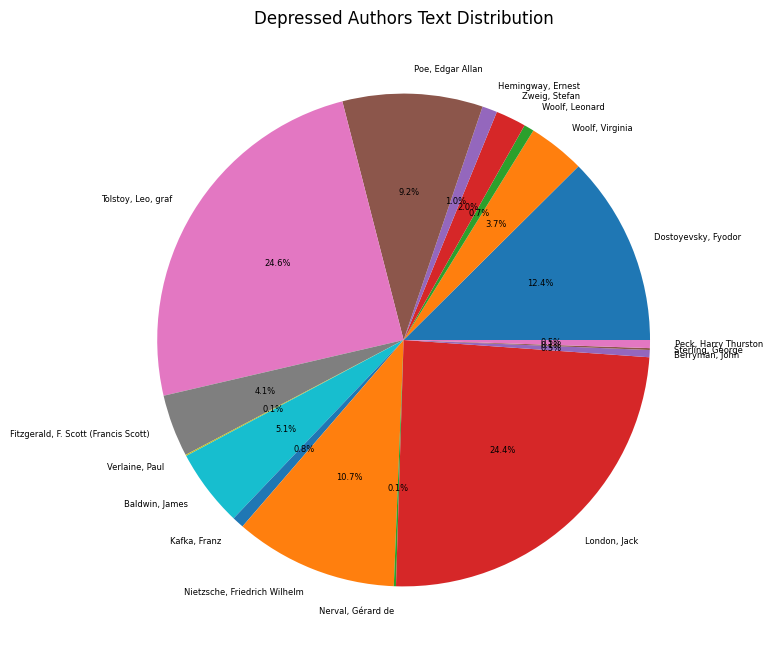

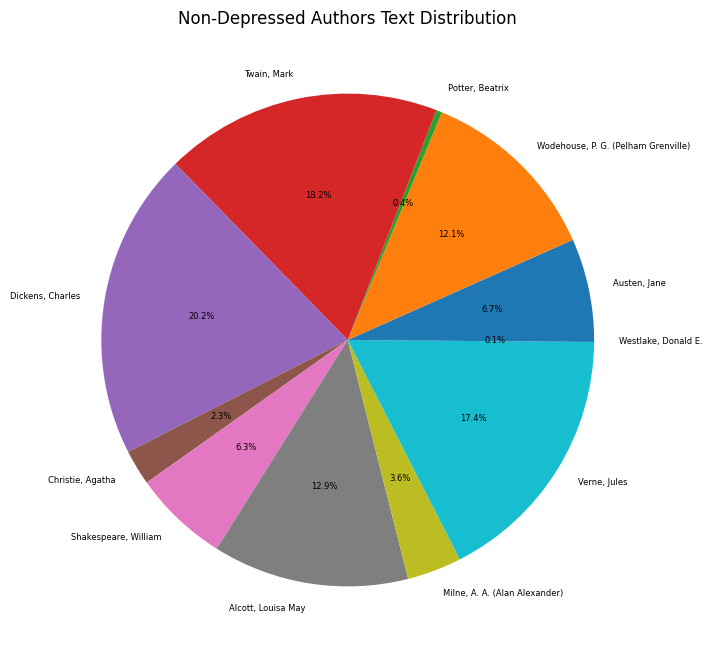

In [92]:
plot_pie_chart(sad_dict, "Depressed Authors Text Distribution")
plot_pie_chart(happy_dict, "Non-Depressed Authors Text Distribution")

Word Frequency

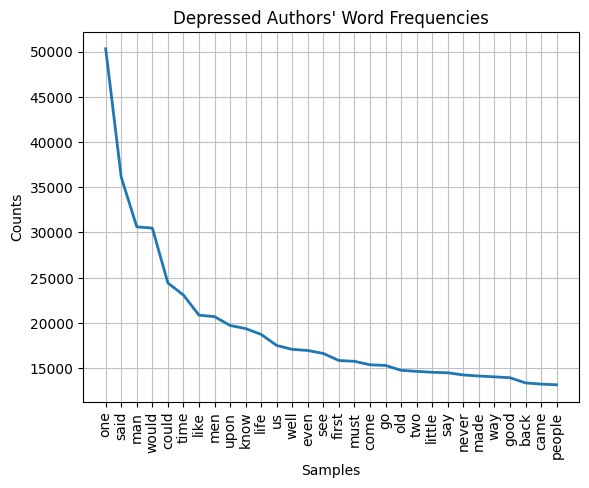

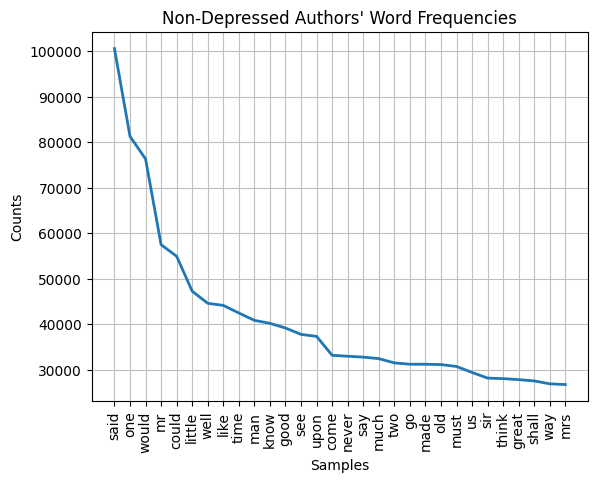

In [11]:
plt.title("Depressed Authors' Word Frequencies")
fdist = FreqDist(sad_filtered_tokens)
most_common = fdist.most_common(10)
plot1 = fdist.plot(30, cumulative=False)

plt.title("Non-Depressed Authors' Word Frequencies")
fdist = FreqDist(happy_filtered_tokens)
most_common = fdist.most_common(10)
plot2 = fdist.plot(30, cumulative=False)



Word Cloud

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sad_filtered_text)
plt.figure(figsize=(10, 5))
plt.title("Depressed Authors Word Cloud")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(happy_filtered_text)
plt.figure(figsize=(10, 5))
plt.title("Non-Depressed Authors Word Cloud")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Sentence Length

In [13]:
sentences = nltk.sent_tokenize(sad_all_text.decode('utf-8'))
total_words = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences)
num_sentences = len(sentences)
average_sentence_length = total_words / num_sentences
print("Depressed Authors Average Sentence Length:", average_sentence_length)

sentences = nltk.sent_tokenize(happy_all_text.decode('utf-8'))
total_words = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences)
num_sentences = len(sentences)
average_sentence_length = total_words / num_sentences
print("Non-Depressed Authors Average Sentence Length:", average_sentence_length)

Depressed Authors Average Sentence Length: 21.83533415451131
Non-Depressed Authors Average Sentence Length: 20.895208744114147


Process Data for ML

In [93]:
# Read the dictionaries, append, create df
texts = []
for author in sad_dict.keys():
  for work in sad_dict[author].keys():
    texts.append([author,work,sad_dict[author][work]["cleaned_text"],1])
for author in happy_dict.keys():
  for work in happy_dict[author].keys():
    texts.append([author,work,happy_dict[author][work]["cleaned_text"],0])
data = pd.DataFrame(texts, columns = ["Author","Work","Text","Target"])

# Remove illustration phrases used for pictures
data["Text"] = data["Text"].apply(lambda x: x.replace("illustration",""))

# Get the 0.8 middle chunk of the text to avoid Project Gutenberg information
data["Text"] = data["Text"].apply(lambda x : get_middle_section_by_pct(x,0.8))

# Get a fixed amount of words from each work from the middle of text
#data["Text"] = data["Text"].apply(lambda x : get_middle_section_by_words(x,1000))

# Calculate Total Words and Chars
data["Words"] = data["Text"].apply(lambda x : len(x.split(" ")))
data["Chars"] = data["Text"].apply(lambda x : len(x))

print(data.shape)

df_author_grouped = pd.concat([data.groupby("Author")["Text"].sum().reset_index(),
                               data.groupby("Author")["Target"].mean().astype(int).reset_index(drop = True),
                               data.groupby("Author")["Work"].size().reset_index(drop = True),

],1).rename(columns = {"Work":"Works"})
df_author_grouped["Words"] = df_author_grouped["Text"].apply(lambda x : len(x.split(" ")))
df_author_grouped["Chars"] = df_author_grouped["Text"].apply(lambda x : len(x))
df_author_grouped = df_author_grouped.sort_values(["Target","Words"]).reset_index(drop = True)


df_author_grouped = df_author_grouped[~df_author_grouped["Author"].isin(["Twain, Mark","Dickens, Charles"])].reset_index(drop = True)
author_info_cumulative = pd.concat([df_author_grouped,pd.concat([df_author_grouped[df_author_grouped["Target"] == 0][::-1].cumsum(),df_author_grouped[df_author_grouped["Target"] == 1][::-1].cumsum()])[["Words"]]
                                    ,pd.concat([df_author_grouped[df_author_grouped["Target"] == 0][::-1].cumsum(),df_author_grouped[df_author_grouped["Target"] == 1][::-1].cumsum()])[["Works"]]
                                    ],1)
author_info_cumulative.columns = ["Author","Text","Target","Works","Words","Chars","Words_cumsum","Works_cumsum"]
author_info_cumulative["Word_cumsum_pct"] = pd.concat([author_info_cumulative[author_info_cumulative["Target"] == 0] ["Words_cumsum"] / author_info_cumulative.loc[author_info_cumulative["Target"] == 0,"Words_cumsum"].max(),
           author_info_cumulative[author_info_cumulative["Target"] == 1] ["Words_cumsum"] / author_info_cumulative.loc[author_info_cumulative["Target"] == 1,"Words_cumsum"].max() ] )
author_info_cumulative

(655, 6)


<ipython-input-93-616fc824bcdb>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_author_grouped = pd.concat([data.groupby("Author")["Text"].sum().reset_index(),
<ipython-input-93-616fc824bcdb>:37: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  author_info_cumulative = pd.concat([df_author_grouped,pd.concat([df_author_grouped[df_author_grouped["Target"] == 0][::-1].cumsum(),df_author_grouped[df_author_grouped["Target"] == 1][::-1].cumsum()])[["Words"]]


,Author,Text,Target,Works,Words,Chars,Words_cumsum,Works_cumsum,Word_cumsum_pct
0,"Westlake, Donald E.","done before mccanns death, the premium money c...",0,4,23106,127413,11273470,265,1.000000
1,"Potter, Beatrix","""alack,"" said the tailor, ""i have my twist; bu...",0,22,65074,357981,11250364,261,0.997950
2,"Christie, Agatha","old servant hesitated, then added diffidently:...",0,11,429713,2348437,11185290,239,0.992178
3,"Milne, A. A. (Alan Alexander)","right-handed,"" i said. ""i played that way by m...",0,18,658356,3594839,10755577,228,0.954061
4,"Shakespeare, William",drest in a little brief authority. measure for...,0,61,1062134,5762584,10097221,210,0.895662
5,"Austen, Jane","world, no species of composition has been so m...",0,11,1328623,7360158,9035087,149,0.801447
6,"Wodehouse, P. G. (Pelham Grenville)",sensed it with every nerve of his apprehensive...,0,45,2235940,12212430,7706464,138,0.683593
7,"Alcott, Louisa May","climbing, christie decided not to try going ou...",0,44,2321377,12393642,5470524,93,0.485256
8,"Verne, Jules",faint in the distance. our steam-ship ranged n...,0,49,3149147,18022496,3149147,49,0.279341
9,"Verlaine, Paul","god, yes. (a short pause during which marie lo...",1,2,7231,40211,10265537,204,1.000000


Decide the Splits

Random sampling brute force to find a balanced author split, this is a heuristic algorithm, it is not deterministic, it converges to same answers with high iterations. Your optimal dictionary may not be the same as mine.

In [94]:
%%capture
from random import sample
params_scores = []
indexes = []
doubles = []
chosen_train_indexes,chosen_val_indexes,chosen_test_indexes = [1,2], [3,4], [5,6]
for aq in range(1,8):
  for bq in range(1,8):
    for cq in range(1,8):
      for dq in range(1,8):
        for _ in range(100):
          if [chosen_train_indexes,chosen_val_indexes,chosen_test_indexes] not in params_scores:
            try:
              indexes_0 = author_info_cumulative[author_info_cumulative["Target"] == 0].index.values
              indexes_1 = author_info_cumulative[author_info_cumulative["Target"] == 1].index.values
              all_indexes = author_info_cumulative.index.values

              chosen_test_indexes = np.concatenate([np.random.choice(indexes_0, aq, replace = False), np.random.choice(indexes_1, bq, replace = False)])
              chosen_train_indexes = np.delete(all_indexes, chosen_test_indexes)

              chosen_train_indexes_0, chosen_train_indexes_1 = np.intersect1d(chosen_train_indexes, indexes_0), np.intersect1d(chosen_train_indexes, indexes_1)
              chosen_val_indexes = np.concatenate([np.random.choice(chosen_train_indexes_0, cq, replace = False), np.random.choice(chosen_train_indexes_1, dq, replace = False)])

              chosen_train_indexes = np.delete(chosen_train_indexes, chosen_val_indexes)


              train_dict = {i:"train" for i in author_info_cumulative.iloc[np.r_[chosen_train_indexes]]["Author"].values}
              test_dict = {i:"test" for i in author_info_cumulative.iloc[np.r_[chosen_test_indexes]]["Author"].values}
              val_dict = {i:"val" for i in author_info_cumulative.iloc[np.r_[chosen_val_indexes]]["Author"].values}

              author_split_dict = train_dict | test_dict | val_dict
              author_info_cumulative["Split"] = author_info_cumulative["Author"].map(author_split_dict)
              data["Split"] = data["Author"].map(author_split_dict)
              df = data.copy()
              train, test, val = df[df["Split"] == "train"], df[df["Split"] == "test"], df[df["Split"] == "val"]
              X_train, X_val, X_test = train["Text"].values, val["Text"].values, test["Text"].values
              y_train, y_val, y_test = train["Target"].values, val["Target"].values,test["Target"].values

              x,y,z = print_split_stats(X_train, X_val, X_test , y_train, y_val, y_test, train, val, test)
              score = np.abs(x[0] - 0.5) + np.abs(y[0] - 0.5) +  np.abs(z[0] - 0.5)
              params_scores.append([author_split_dict,len(train_dict),len(val_dict),len(test_dict),x[0],y[0],z[0],score])
              indexes.append([chosen_train_indexes,chosen_val_indexes,chosen_test_indexes])
              #print(test)
            except:
              pass
          else:
            doubles.append([chosen_train_indexes,chosen_val_indexes,chosen_test_indexes])

In [95]:
params_scores = pd.DataFrame(params_scores, columns = ["dict","nof_train_authors","nof_val_authors","nof_test_authors","train_balance","val_balance","test_balance","score"])
params_scores = params_scores[(params_scores["nof_train_authors"] > params_scores["nof_test_authors"]) & (params_scores["nof_train_authors"] > params_scores["nof_val_authors"])].sort_values("score").reset_index(drop = True)
optimal_dict, optimal_score = params_scores.iloc[0,0], params_scores.iloc[0,1]
print(optimal_dict)
params_scores.head(10)

{'Westlake, Donald E.': 'train', 'Potter, Beatrix': 'train', 'Christie, Agatha': 'train', 'Milne, A. A. (Alan Alexander)': 'train', 'Austen, Jane': 'val', 'Alcott, Louisa May': 'train', 'Verne, Jules': 'train', 'Verlaine, Paul': 'val', 'Berryman, John': 'train', 'Peck, Harry Thurston': 'train', 'Woolf, Leonard': 'val', 'Zweig, Stefan': 'train', 'Woolf, Virginia': 'train', 'Dostoyevsky, Fyodor': 'train', 'London, Jack': 'train', 'Tolstoy, Leo, graf': 'train', 'Shakespeare, William': 'test', 'Poe, Edgar Allan': 'test', 'Fitzgerald, F. Scott (Francis Scott)': 'test', 'Baldwin, James': 'test', 'Nietzsche, Friedrich Wilhelm': 'test', 'Sterling, George': 'val', 'Kafka, Franz': 'val'}


,dict,nof_train_authors,nof_val_authors,nof_test_authors,train_balance,val_balance,test_balance,score
0,"{'Westlake, Donald E.': 'train', 'Potter, Beat...",16,5,5,0.530466,0.578947,0.504132,0.113546
1,"{'Westlake, Donald E.': 'train', 'Christie, Ag...",21,3,2,0.544850,0.486486,0.564103,0.122467
2,"{'Westlake, Donald E.': 'train', 'Christie, Ag...",18,4,4,0.659824,0.523810,0.500000,0.183634
3,"{'Westlake, Donald E.': 'train', 'Potter, Beat...",16,4,6,0.591270,0.500000,0.603448,0.194718
4,"{'Milne, A. A. (Alan Alexander)': 'train', 'Sh...",19,3,4,0.565757,0.500000,0.634615,0.200372
5,"{'Potter, Beatrix': 'train', 'Austen, Jane': '...",15,5,6,0.672727,0.500000,0.532544,0.205272
6,"{'Westlake, Donald E.': 'train', 'Christie, Ag...",14,4,8,0.500000,0.620690,0.586735,0.207424
7,"{'Christie, Agatha': 'val', 'Austen, Jane': 't...",14,5,7,0.556150,0.555556,0.598592,0.210297
8,"{'Westlake, Donald E.': 'train', 'Potter, Beat...",22,2,2,0.585714,0.611111,0.521277,0.218102
9,"{'Potter, Beatrix': 'train', 'Christie, Agatha...",20,4,2,0.597938,0.379310,0.500000,0.218628


Deciding the Dictionary

In [96]:
optimal_dict = {'Westlake, Donald E.': 'train',
 'Christie, Agatha': 'train',
 'Milne, A. A. (Alan Alexander)': 'val',
 'Austen, Jane': 'val',
 'Alcott, Louisa May': 'train',
 'Verne, Jules': 'train',
 'Verlaine, Paul': 'train',
 'Sterling, George': 'train',
 'Nerval, Gérard de': 'train',
 'Berryman, John': 'val',
 'Woolf, Leonard': 'train',
 'Kafka, Franz': 'val',
 'Zweig, Stefan': 'train',
 'Woolf, Virginia': 'val',
 'Baldwin, James': 'val',
 'Dostoyevsky, Fyodor': 'train',
 'London, Jack': 'train',
 'Tolstoy, Leo, graf': 'train',
 'Potter, Beatrix': 'test',
 'Nietzsche, Friedrich Wilhelm': 'test'}

Split the Data and Inspect

In [97]:
data["Split"] = data["Author"].map(optimal_dict)
df = data.copy()
train, val, test = df[df["Split"] == "train"], df[df["Split"] == "val"] ,df[df["Split"] == "test"]
X_train, X_val, X_test = train["Text"].values, val["Text"].values, test["Text"].values
y_train, y_val, y_test = train["Target"].values, val["Target"].values, test["Target"].values
print_split_stats(X_train, X_val,X_test , y_train, y_val, y_test, train, val, test)

data target dist =
 0    0.68855
1    0.31145
Name: Target, dtype: float64
train val test ratio =  0.6966966966964875 0.16516516516511556 0.13813813813809667
train val test target dist =  1    0.534483
0    0.465517
Name: Target, dtype: float64 0    0.527273
1    0.472727
Name: Target, dtype: float64 1    0.521739
0    0.478261
Name: Target, dtype: float64
X_train shape = (232,)
 X_val shape = (55,)
 X_test shape = (46,)
 y_train shape = (232,)
 y_val shape = (55,)
 y_test shape = (46,)
 train shape = (232, 7)
 test shape = (46, 7)


(1    0.534483
 0    0.465517
 Name: Target, dtype: float64,
 0    0.527273
 1    0.472727
 Name: Target, dtype: float64,
 1    0.521739
 0    0.478261
 Name: Target, dtype: float64)

TFID_Vectorized Data + Logistic Regression

In [98]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')

In [99]:
X_train_tfidv = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidv = tfidf_vectorizer.transform(X_test)
X_val_tfidv = tfidf_vectorizer.transform(X_val)
tfidf_tokens = tfidf_vectorizer.get_feature_names_out()
vector_df = pd.DataFrame(X_train_tfidv.toarray(), columns=tfidf_tokens).T

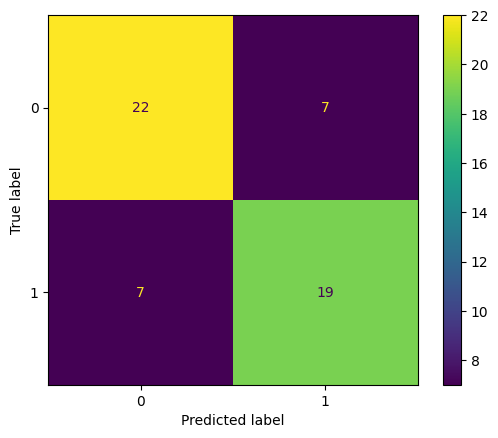

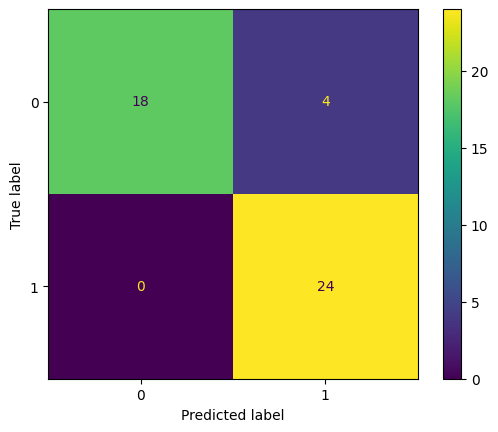

In [100]:
lr = LogisticRegression()
lr.fit(X_train_tfidv, y_train)
lr_preds = lr.predict(X_test_tfidv)
lr_preds_proba = lr.predict_proba(X_test_tfidv)

lr_val_preds = lr.predict(X_val_tfidv)

#accuracy, precision, recall, f1, cohen_kappa
val_results = print_classification_metrics(y_val,lr_val_preds,lr.classes_)
test_results = print_classification_metrics(y_test,lr_preds,lr.classes_)

<Axes: title={'center': 'LR Coefs'}>

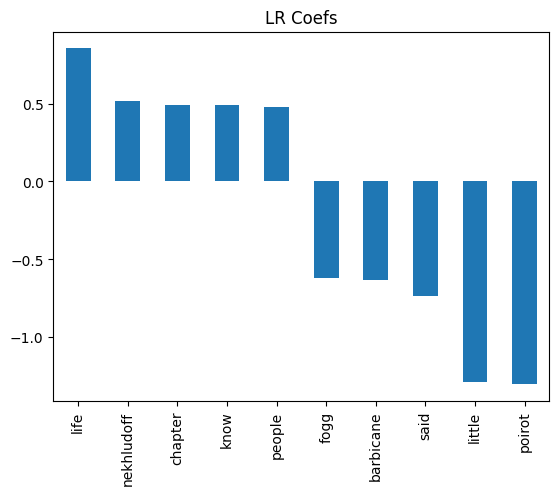

In [15]:
vector_df = pd.DataFrame(X_train_tfidv.toarray(), columns=tfidf_tokens).T
vector_df["coef"] = lr.coef_.T
vector_df = vector_df[vector_df.index.str.len() > 3]
vector_df = vector_df.sort_values("coef", ascending = False)#["coef"]
pd.concat([vector_df.head(5), vector_df.tail(5)])["coef"].plot(kind = "bar",title="LR Coefs")

Original Data + CatBoost with Text Features

In [16]:
cat = CatBoostClassifier()
train_data = Pool(data=X_train, label=y_train, text_features=[0])
cat.fit(train_data, verbose = 0)
test_data = Pool(data=X_test, label=y_test, text_features=[0])
val_data = Pool(data=X_val, label=y_val, text_features=[0])
cat_preds = cat.predict(test_data)
cat_val_preds = cat.predict(val_data)

In [70]:
df.loc[val.index,"lr_preds"] = lr_val_preds
df.loc[val.index,"cat_preds"] = cat_val_preds
df.loc[test.index,"lr_preds"] = lr_preds
df.loc[test.index,"cat_preds"] = cat_preds
df.loc[test.index,"nn_preds"] = [1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]
df.loc[val.index,"nn_preds"] = [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,0., 0., 0.,0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,  0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.]


In [71]:
results_df = df[df["Split"]!="train"].dropna()
results_df.head(60)

,Author,Work,Text,Target,Words,Chars,Split,lr_preds,cat_preds,nn_preds
14,"Woolf, Virginia",Jacob's Room,crescent upon the underwing. the tree had fall...,1,43601,249156,val,0.0,1.0,0.0
15,"Woolf, Virginia",Monday or Tuesday,(now disguised as a private gentleman) and dem...,1,14492,81949,val,1.0,1.0,0.0
16,"Woolf, Virginia",Night and Day,every day im at it. katharine looked at ralph ...,1,133016,743850,val,0.0,1.0,0.0
17,"Woolf, Virginia",Mr. Bennett and Mrs. Brown,more solemn instances of the power of the huma...,1,6308,35517,val,0.0,1.0,1.0
18,"Woolf, Virginia",Mrs Dalloway in Bond Street,stroke. the leaden circles dissolved in the ai...,1,2453,14144,val,1.0,0.0,0.0
19,"Woolf, Virginia",The Common Reader,verbal victory. the humour of the people was n...,1,65584,371863,val,1.0,1.0,0.0
20,"Woolf, Virginia",The Voyage Out,"youre going to swallow it; but persevere, and ...",1,109066,601504,val,0.0,0.0,0.0
104,"Baldwin, James",Fifty Famous People: A Book of Short Stories,resting or eating his dinner. one dark night j...,1,25393,132963,val,0.0,1.0,0.0
105,"Baldwin, James",The Story of Siegfried,doubting but that odin has many good things in...,1,62708,343319,val,1.0,0.0,0.0
106,"Baldwin, James","Four Great Americans: Washington, Franklin, We...",and nothing would do but that he must spend th...,1,31145,167257,val,1.0,0.0,1.0


In [72]:
lr_val_preds = results_df.loc[results_df["Split"] == "val","lr_preds"]
cat_val_preds = results_df.loc[results_df["Split"] == "val","cat_preds"]
lr_test_preds = results_df.loc[results_df["Split"] == "test","lr_preds"]
cat_test_preds = results_df.loc[results_df["Split"] == "test","cat_preds"]
nn_val_preds = results_df.loc[results_df["Split"] == "val","nn_preds"]
nn_test_preds = results_df.loc[results_df["Split"] == "test","nn_preds"]

lr_preds = results_df["lr_preds"]
cat_preds = results_df["cat_preds"]
nn_preds = results_df["nn_preds"]
y = results_df["Target"]

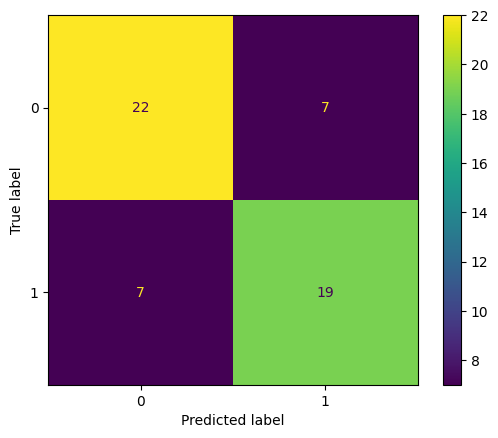

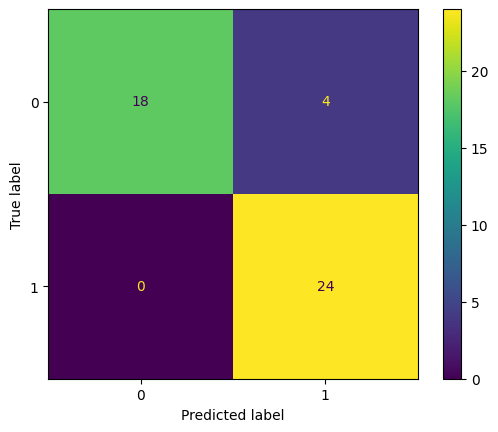

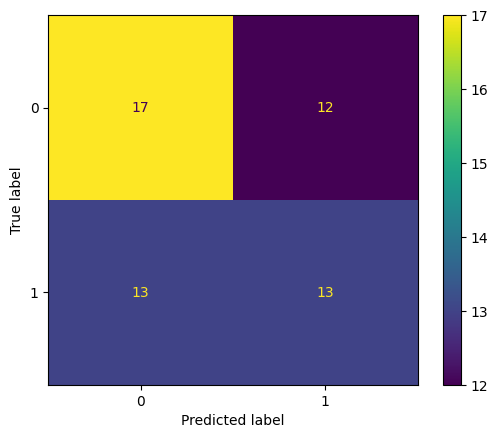

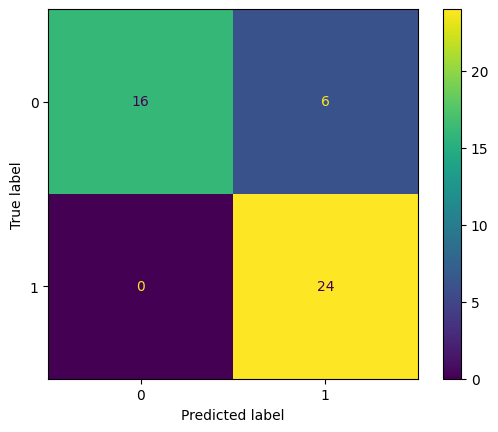

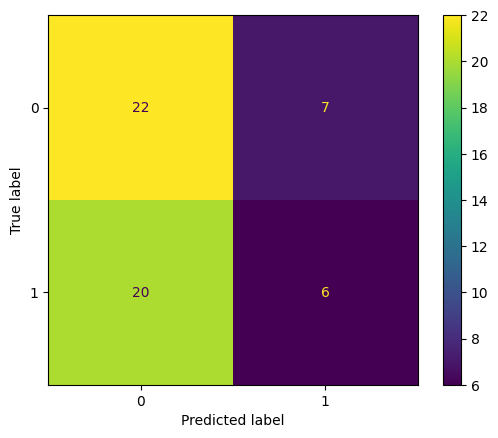

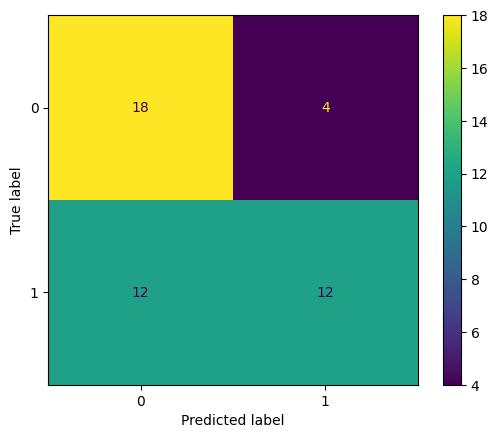

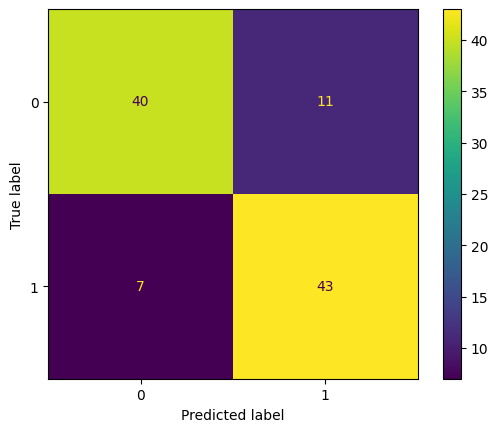

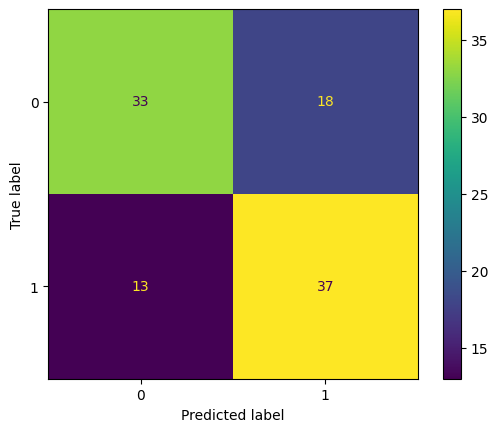

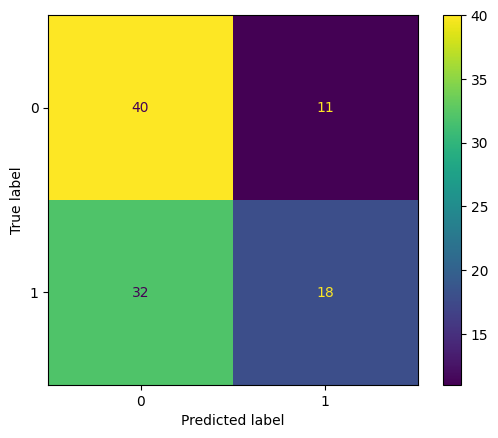

In [81]:
lr_val_res = print_classification_metrics(y_val, lr_val_preds, lr.classes_)
lr_test_res = print_classification_metrics(y_test, lr_test_preds, lr.classes_)
cat_val_res = print_classification_metrics(y_val, cat_val_preds, cat.classes_)
cat_test_res = print_classification_metrics(y_test, cat_test_preds, cat.classes_)
nn_val_res = print_classification_metrics(y_val, nn_val_preds, cat.classes_)
nn_test_res = print_classification_metrics(y_test, nn_test_preds, cat.classes_)
lr_res = print_classification_metrics(y, lr_preds, lr.classes_)
cat_res = print_classification_metrics(y, cat_preds, cat.classes_)
nn_res = print_classification_metrics(y, nn_preds, cat.classes_)

In [83]:
np.round(df[df["Split"]!="train"].dropna().groupby("Author").mean(),0).sort_values("Target").drop(["Words","Chars"],1)

<ipython-input-83-caf2afd8e3db>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  np.round(df[df["Split"]!="train"].dropna().groupby("Author").mean(),0).sort_values("Target").drop(["Words","Chars"],1)
<ipython-input-83-caf2afd8e3db>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  np.round(df[df["Split"]!="train"].dropna().groupby("Author").mean(),0).sort_values("Target").drop(["Words","Chars"],1)


,Target,lr_preds,cat_preds,nn_preds
Author,,,,
"Austen, Jane",0.0,0.0,0.0,0.0
"Milne, A. A. (Alan Alexander)",0.0,0.0,1.0,0.0
"Potter, Beatrix",0.0,0.0,0.0,0.0
"Baldwin, James",1.0,1.0,0.0,0.0
"Berryman, John",1.0,1.0,1.0,0.0
"Kafka, Franz",1.0,1.0,1.0,0.0
"Nietzsche, Friedrich Wilhelm",1.0,1.0,1.0,0.0
"Woolf, Virginia",1.0,0.0,1.0,0.0


In [75]:
all_results = pd.DataFrame([lr_val_res,lr_test_res,lr_res,cat_val_res,cat_test_res,cat_res,nn_val_res,nn_test_res,nn_res], columns = ["accuracy", "precision", "recall", "f1", "cohen_kappa"], index = ["LR VAL","LR TEST","LR ALL","CAT VAL","CAT TEST","CAT ALL","NN VAL","NN TEST","NN ALL"])

In [80]:
final_df = np.round(all_results[2::3],2)
final_df.index = ["LR","CAT","NN"]
final_df

,accuracy,precision,recall,f1,cohen_kappa
LR,0.82,0.80,0.86,0.83,0.64
CAT,0.69,0.67,0.74,0.70,0.39
NN,0.57,0.62,0.36,0.46,0.14


<Axes: >

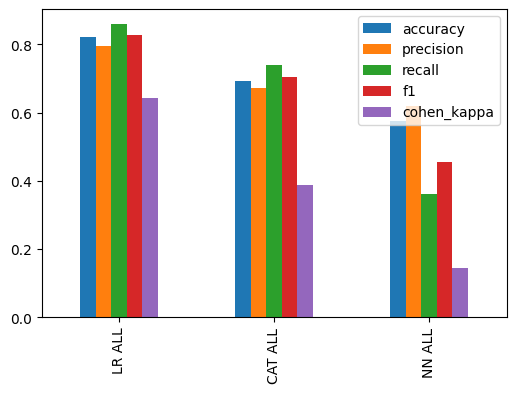

In [77]:
all_results[2::3].plot(kind = "bar", figsize = (6,4))